## Investigate trimming

In [1]:
from scipy.stats import qmc
import numpy as np

import csv
import xarray as xr
import pandas as pd
import os
import netCDF4 as nc4
import sys
import shutil
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                                                                                                                                                                       
import tempfile 
import random
import re

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib.colors import BoundaryNorm
import cartopy.crs as ccrs

import functions_py.fates_xarray_functions as fa

In [2]:
pftnames = ['broadleaf_evergreen_tropical_tree','needleleaf_evergreen_extratrop_tree',
         'needleleaf_colddecid_extratrop_tree','broadleaf_evergreen_extratrop_tree',
        'broadleaf_hydrodecid_tropical_tree','broadleaf_colddecid_extratrop_tree',
        'broadleaf_evergreen_extratrop_shrub','broadleaf_hydrodecid_extratrop_shrub',
        'broadleaf_colddecid_extratrop_shrub', 'arctic_c3_grass',
        'cool_c3_grasss','c4_grass']

### Load the fates runs
1. Trimming reduced by 10%
2. Default trimming
3. Trimming increased by 10%
4. No trimming

In [3]:
fates = '/pscratch/sd/j/jneedham/elm_runs/fbnc_cal/default_trim.Eb8be65d66e-F3a2becda.2023-10-26/run/default_trim.Eb8be65d66e-F3a2becda.2023-10-26.1920s.nc'
fates = xr.open_dataset(fates, decode_times=False)

fates_notrim = '/pscratch/sd/j/jneedham/elm_runs/fbnc_cal/notrim.Eb8be65d66e-F3a2becda.2023-10-26/run/notrim.Eb8be65d66e-F3a2becda.2023-10-26.1920s.nc'
fates_notrim = xr.open_dataset(fates_notrim, decode_times=False)

fates_lowtrim = '/pscratch/sd/j/jneedham/elm_runs/fbnc_cal/lowtrim.Eb8be65d66e-F3a2becda.2023-10-26/run/lowtrim.Eb8be65d66e-F3a2becda.2023-10-26.1920s.nc'
fates_lowtrim = xr.open_dataset(fates_lowtrim, decode_times=False)

fates_hightrim = '/pscratch/sd/j/jneedham/elm_runs/fbnc_cal/hightrim.Eb8be65d66e-F3a2becda.2023-10-26/run/hightrim.Eb8be65d66e-F3a2becda.2023-10-26.1920s.nc'
fates_hightrim = xr.open_dataset(fates_hightrim, decode_times=False)

time = fates.variables['time'] / 365.
cohort_size_bins = fates.variables['fates_levscls'][:]
nsizebins = len(cohort_size_bins)

### LAI 

In [4]:
lai_canopy = fa.scpf_to_scls_by_pft(fates.FATES_LAI_CANOPY_SZPF, fates) * fates.FATES_FRACTION.mean(dim='time')
lai_canopy = lai_canopy.sum(dim='fates_levscls').mean(dim='time')
lai_ustory = fa.scpf_to_scls_by_pft(fates.FATES_LAI_USTORY_SZPF, fates) * fates.FATES_FRACTION.mean(dim='time')
lai_ustory = lai_ustory.sum(dim='fates_levscls').mean(dim='time')
lai = lai_canopy+lai_ustory

lai_canopy_notrim = fa.scpf_to_scls_by_pft(fates_notrim.FATES_LAI_CANOPY_SZPF, fates_notrim) * fates_notrim.FATES_FRACTION.mean(dim='time')
lai_canopy_notrim = lai_canopy_notrim.sum(dim='fates_levscls').mean(dim='time')
lai_ustory_notrim = fa.scpf_to_scls_by_pft(fates_notrim.FATES_LAI_USTORY_SZPF, fates_notrim) * fates_notrim.FATES_FRACTION.mean(dim='time')
lai_ustory_notrim = lai_ustory_notrim.sum(dim='fates_levscls').mean(dim='time')
lai_notrim = lai_canopy_notrim + lai_ustory_notrim

lai_canopy_lowtrim = fa.scpf_to_scls_by_pft(fates_lowtrim.FATES_LAI_CANOPY_SZPF, fates_lowtrim) * fates_lowtrim.FATES_FRACTION.mean(dim='time')
lai_canopy_lowtrim = lai_canopy_lowtrim.sum(dim='fates_levscls').mean(dim='time')
lai_ustory_lowtrim = fa.scpf_to_scls_by_pft(fates_lowtrim.FATES_LAI_USTORY_SZPF, fates_lowtrim) * fates_lowtrim.FATES_FRACTION.mean(dim='time')
lai_ustory_lowtrim = lai_ustory_lowtrim.sum(dim='fates_levscls').mean(dim='time')
lai_lowtrim = lai_canopy_lowtrim + lai_ustory_lowtrim

lai_canopy_hightrim = fa.scpf_to_scls_by_pft(fates_hightrim.FATES_LAI_CANOPY_SZPF, fates_hightrim) * fates_hightrim.FATES_FRACTION.mean(dim='time')
lai_canopy_hightrim = lai_canopy_hightrim.sum(dim='fates_levscls').mean(dim='time')
lai_ustory_hightrim = fa.scpf_to_scls_by_pft(fates_hightrim.FATES_LAI_USTORY_SZPF, fates_hightrim) * fates_hightrim.FATES_FRACTION.mean(dim='time')
lai_ustory_hightrim = lai_ustory_hightrim.sum(dim='fates_levscls').mean(dim='time')
lai_hightrim = lai_canopy_hightrim + lai_ustory_hightrim

lais = [lai_notrim, lai_lowtrim, lai, lai_hightrim]

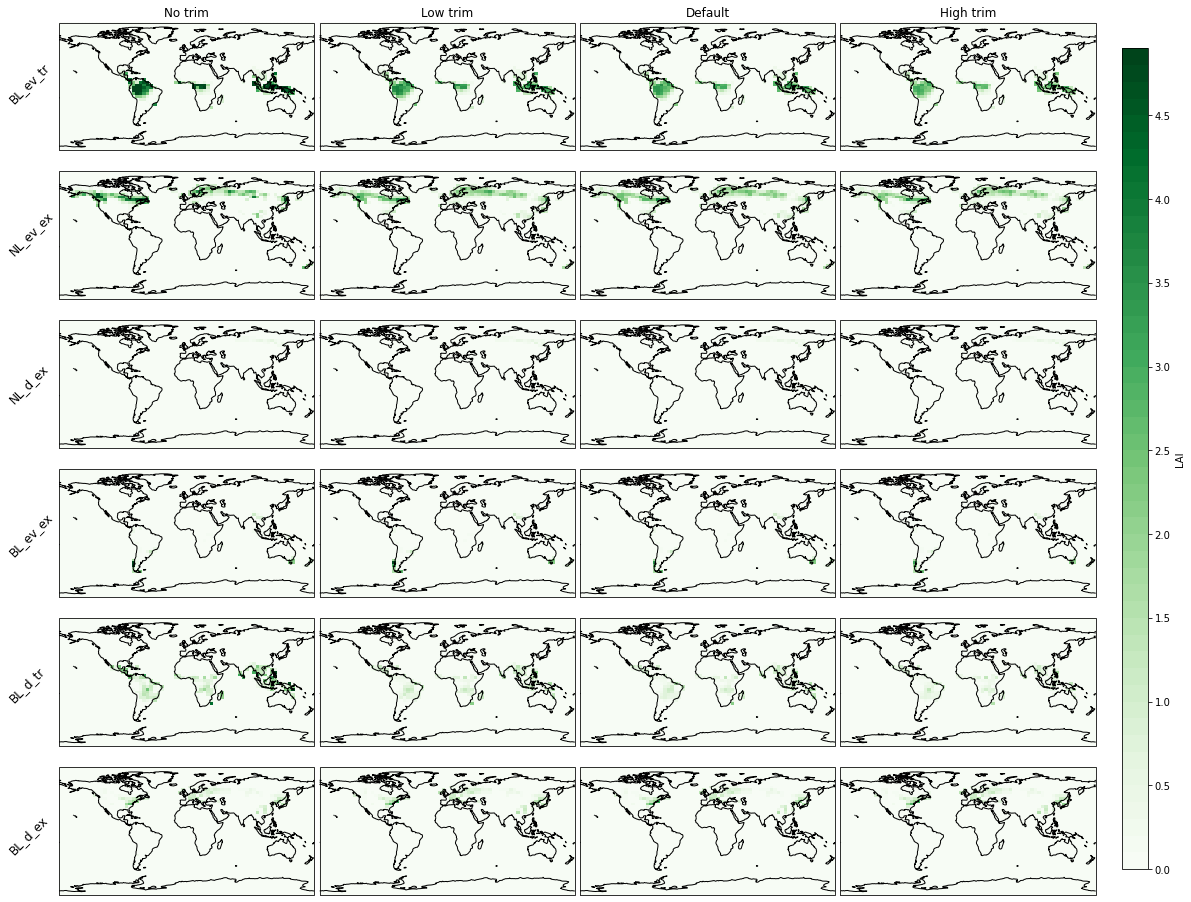

In [5]:
clevs=np.arange(0,5,0.1)
fig, axs = plt.subplots(nrows=6,ncols=4,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,19))
for j in range(0,4):
    tmp = lais[j]
    
    for i in range(0,6):
            cs= tmp.isel(fates_levpft=i).plot(levels=clevs,cmap='Greens',
            ax=axs[i,j],add_colorbar=False)
            axs[i,j].coastlines()
            axs[i,j].set_title('')
            
axs[0,0].set_title('No trim', fontsize=12)
axs[0,1].set_title('Low trim', fontsize=12)
axs[0,2].set_title('Default', fontsize=12)
axs[0,3].set_title('High trim', fontsize=12)

fig.text(0.06, 0.85, 'BL_ev_tr', va='center', rotation=45.0, fontsize=12)
fig.text(0.06, 0.74, 'NL_ev_ex', va='center', rotation=45.0, fontsize=12)
fig.text(0.06, 0.63, 'NL_d_ex', va='center', rotation=45.0, fontsize=12)
fig.text(0.06, 0.52, 'BL_ev_ex', va='center', rotation=45.0, fontsize=12)
fig.text(0.06, 0.41, 'BL_d_tr', va='center', rotation=45.0, fontsize=12)
fig.text(0.06, 0.3, 'BL_d_ex', va='center', rotation=45.0, fontsize=12)

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('LAI')

### Growth rates

##### Nplant

In [6]:
nplant_c = fa.scpf_to_scls_by_pft(fates.FATES_NPLANT_CANOPY_SZPF, fates) * fates.FATES_FRACTION
nplant_c = nplant_c.sum(dim='fates_levscls')
nplant_u = fa.scpf_to_scls_by_pft(fates.FATES_NPLANT_USTORY_SZPF, fates) * fates.FATES_FRACTION
nplant_u = nplant_u.sum(dim='fates_levscls')

nplant_c_notrim = fa.scpf_to_scls_by_pft(fates_notrim.FATES_NPLANT_CANOPY_SZPF, fates_notrim) * fates_notrim.FATES_FRACTION
nplant_c_notrim = nplant_c_notrim.sum(dim='fates_levscls')
nplant_u_notrim = fa.scpf_to_scls_by_pft(fates_notrim.FATES_NPLANT_USTORY_SZPF, fates_notrim) * fates_notrim.FATES_FRACTION
nplant_u_notrim = nplant_u_notrim.sum(dim='fates_levscls')

nplant_c_lowtrim = fa.scpf_to_scls_by_pft(fates_lowtrim.FATES_NPLANT_CANOPY_SZPF, fates_lowtrim) * fates_lowtrim.FATES_FRACTION
nplant_c_lowtrim = nplant_c_lowtrim.sum(dim='fates_levscls')
nplant_u_lowtrim = fa.scpf_to_scls_by_pft(fates_lowtrim.FATES_NPLANT_USTORY_SZPF, fates_lowtrim) * fates_lowtrim.FATES_FRACTION
nplant_u_lowtrim = nplant_u_lowtrim.sum(dim='fates_levscls')

nplant_c_hightrim = fa.scpf_to_scls_by_pft(fates_hightrim.FATES_NPLANT_CANOPY_SZPF, fates_hightrim) * fates_hightrim.FATES_FRACTION
nplant_c_hightrim = nplant_c_hightrim.sum(dim='fates_levscls')
nplant_u_hightrim = fa.scpf_to_scls_by_pft(fates_hightrim.FATES_NPLANT_USTORY_SZPF, fates_hightrim) * fates_hightrim.FATES_FRACTION
nplant_u_hightrim = nplant_u_hightrim.sum(dim='fates_levscls')

##### Canopy growth

In [7]:
ddbh_canopy = fa.scpf_to_scls_by_pft(fates.FATES_DDBH_CANOPY_SZPF, fates)* fates.FATES_FRACTION # multiply by fates fraction
ddbh_canopy = ddbh_canopy.sum(dim='fates_levscls') # sum over sizes
ddbh_canopy  = ddbh_canopy / nplant_c # divide by nplant
ddbh_canopy = ddbh_canopy.mean(dim='time') * 100 # mean over time and covert to cm

ddbh_canopy_notrim = fa.scpf_to_scls_by_pft(fates_notrim.FATES_DDBH_CANOPY_SZPF, fates_notrim)* fates_notrim.FATES_FRACTION # multiply by fates fraction
ddbh_canopy_notrim = ddbh_canopy_notrim.sum(dim='fates_levscls') # sum over sizes
ddbh_canopy_notrim  = ddbh_canopy_notrim / nplant_c_notrim # divide by nplant
ddbh_canopy_notrim = ddbh_canopy_notrim.mean(dim='time') * 100 # mean over time

ddbh_canopy_lowtrim = fa.scpf_to_scls_by_pft(fates_lowtrim.FATES_DDBH_CANOPY_SZPF, fates_lowtrim) * fates_lowtrim.FATES_FRACTION 
ddbh_canopy_lowtrim = ddbh_canopy_lowtrim.sum(dim='fates_levscls') # sum over sizes
ddbh_canopy_lowtrim  = ddbh_canopy_lowtrim / nplant_c_lowtrim # divide by nplant
ddbh_canopy_lowtrim = ddbh_canopy_lowtrim.mean(dim='time') * 100 # mean over time

ddbh_canopy_hightrim = fa.scpf_to_scls_by_pft(fates_hightrim.FATES_DDBH_CANOPY_SZPF, fates_hightrim)  * fates_hightrim.FATES_FRACTION 
ddbh_canopy_hightrim = ddbh_canopy_hightrim.sum(dim='fates_levscls') # sum over sizes
ddbh_canopy_hightrim  = ddbh_canopy_hightrim / nplant_c_hightrim # divide by nplant
ddbh_canopy_hightrim = ddbh_canopy_hightrim.mean(dim='time') * 100 # mean over time


##### Ustory growth

In [8]:
ddbh_ustory = fa.scpf_to_scls_by_pft(fates.FATES_DDBH_USTORY_SZPF, fates) * fates.FATES_FRACTION # multiply by fates fraction
ddbh_ustory = ddbh_ustory.sum(dim='fates_levscls') # sum over sizes
ddbh_ustory  = ddbh_ustory / nplant_u # divide by nplant
ddbh_ustory = ddbh_ustory.mean(dim='time') * 100  # mean over time

ddbh_ustory_notrim = fa.scpf_to_scls_by_pft(fates_notrim.FATES_DDBH_USTORY_SZPF, fates_notrim)  * fates_notrim.FATES_FRACTION 
ddbh_ustory_notrim = ddbh_ustory_notrim.sum(dim='fates_levscls') # sum over sizes
ddbh_ustory_notrim  = ddbh_ustory_notrim / nplant_u_notrim # divide by nplant
ddbh_ustory_notrim = ddbh_ustory_notrim.mean(dim='time') * 100 # mean over time

ddbh_ustory_lowtrim = fa.scpf_to_scls_by_pft(fates_lowtrim.FATES_DDBH_USTORY_SZPF, fates_lowtrim) * fates_lowtrim.FATES_FRACTION
ddbh_ustory_lowtrim = ddbh_ustory_lowtrim.sum(dim='fates_levscls') # sum over sizes
ddbh_ustory_lowtrim  = ddbh_ustory_lowtrim / nplant_u_lowtrim # divide by nplant
ddbh_ustory_lowtrim = ddbh_ustory_lowtrim.mean(dim='time') * 100 # mean over time

ddbh_ustory_hightrim = fa.scpf_to_scls_by_pft(fates_hightrim.FATES_DDBH_USTORY_SZPF, fates_hightrim) * fates_hightrim.FATES_FRACTION
ddbh_ustory_hightrim = ddbh_ustory_hightrim.sum(dim='fates_levscls') # sum over sizes
ddbh_ustory_hightrim  = ddbh_ustory_hightrim / nplant_u_hightrim # divide by nplant
ddbh_ustory_hightrim = ddbh_ustory_hightrim.mean(dim='time') * 100 # mean over time


In [9]:
ddbh_ustory_list = [ddbh_ustory_notrim, ddbh_ustory_lowtrim, ddbh_ustory, ddbh_ustory_hightrim]

In [10]:
ddbh_canopy_list = [ddbh_canopy_notrim, ddbh_canopy_lowtrim, ddbh_canopy, ddbh_canopy_hightrim]

### Canopy growth rates

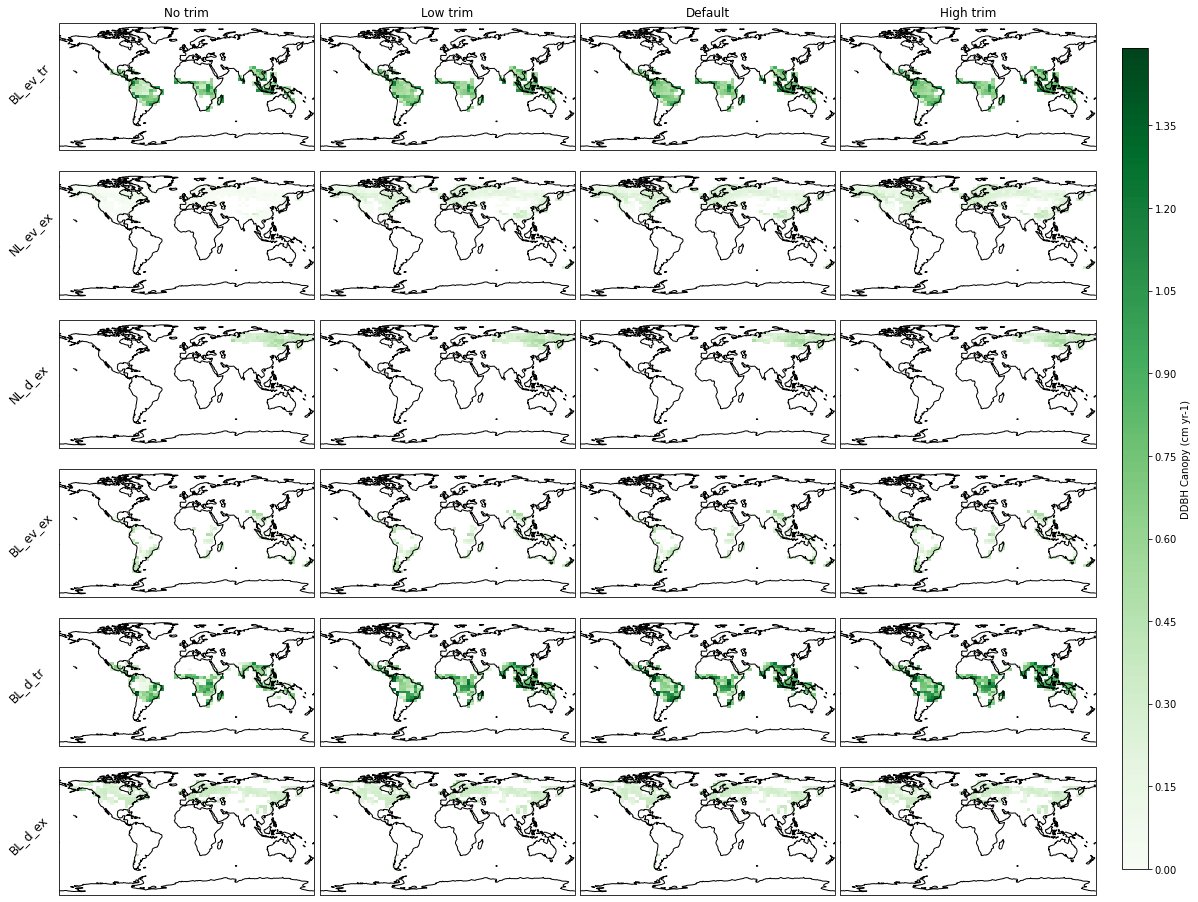

In [11]:
clevs=np.arange(0,1.5,0.01)
fig, axs = plt.subplots(nrows=6,ncols=4,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,19))
for j in range(0,4):
    tmp = ddbh_canopy_list[j]
    
    for i in range(0,6):
            cs= tmp.isel(fates_levpft=i).plot(levels=clevs,cmap='Greens',
            ax=axs[i,j],add_colorbar=False)
            axs[i,j].coastlines()
            axs[i,j].set_title('')
            
axs[0,0].set_title('No trim', fontsize=12)
axs[0,1].set_title('Low trim', fontsize=12)
axs[0,2].set_title('Default', fontsize=12)
axs[0,3].set_title('High trim', fontsize=12)

fig.text(0.06, 0.85, 'BL_ev_tr', va='center', rotation=45.0, fontsize=12)
fig.text(0.06, 0.74, 'NL_ev_ex', va='center', rotation=45.0, fontsize=12)
fig.text(0.06, 0.63, 'NL_d_ex', va='center', rotation=45.0, fontsize=12)
fig.text(0.06, 0.52, 'BL_ev_ex', va='center', rotation=45.0, fontsize=12)
fig.text(0.06, 0.41, 'BL_d_tr', va='center', rotation=45.0, fontsize=12)
fig.text(0.06, 0.3, 'BL_d_ex', va='center', rotation=45.0, fontsize=12)

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('DDBH Canopy (cm yr-1)')

### Understory growth rates

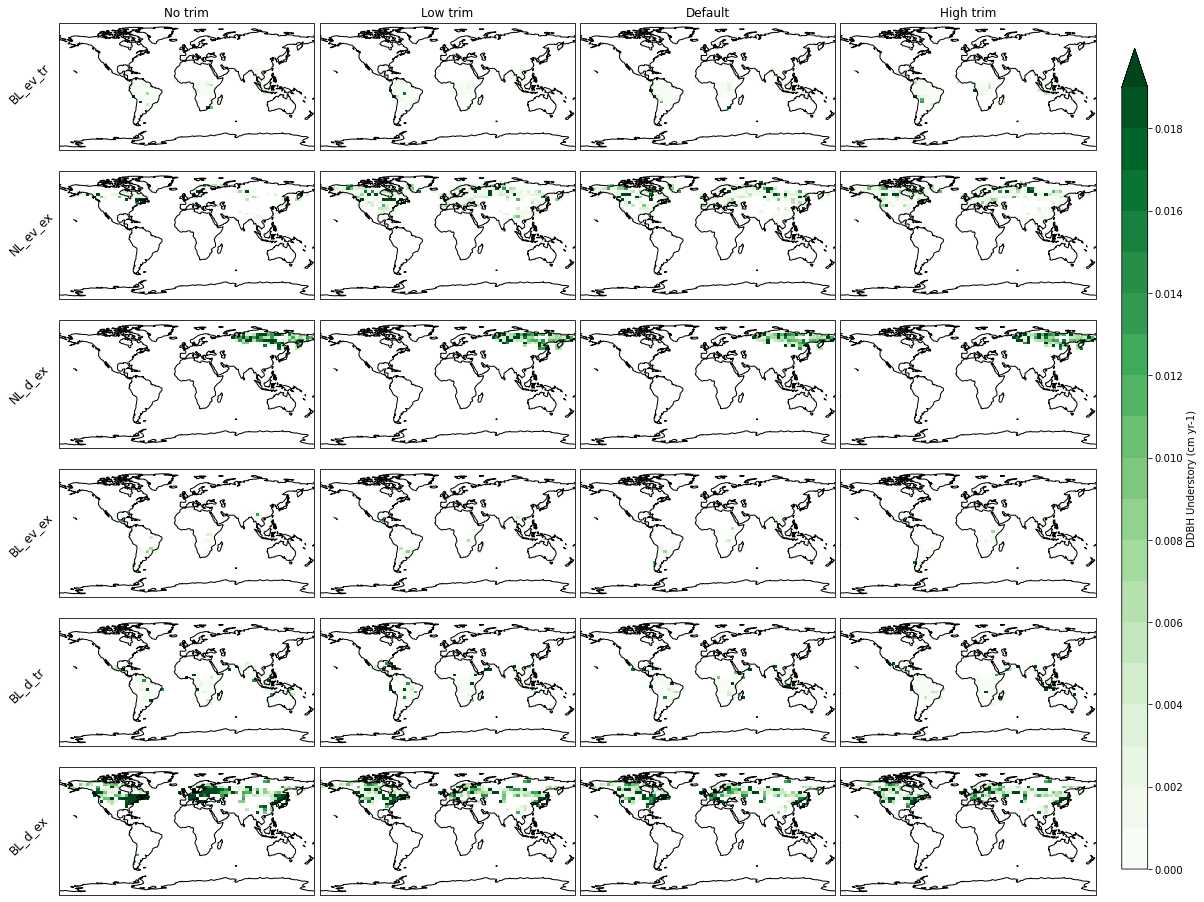

In [12]:
clevs=np.arange(0,0.02,0.001)
fig, axs = plt.subplots(nrows=6,ncols=4,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,19))
for j in range(0,4):
    tmp = ddbh_ustory_list[j]
    
    for i in range(0,6):
            cs= tmp.isel(fates_levpft=i).plot(levels=clevs,cmap='Greens',
            ax=axs[i,j],add_colorbar=False)
            axs[i,j].coastlines()
            axs[i,j].set_title('')
            
axs[0,0].set_title('No trim', fontsize=12)
axs[0,1].set_title('Low trim', fontsize=12)
axs[0,2].set_title('Default', fontsize=12)
axs[0,3].set_title('High trim', fontsize=12)

fig.text(0.06, 0.85, 'BL_ev_tr', va='center', rotation=45.0, fontsize=12)
fig.text(0.06, 0.74, 'NL_ev_ex', va='center', rotation=45.0, fontsize=12)
fig.text(0.06, 0.63, 'NL_d_ex', va='center', rotation=45.0, fontsize=12)
fig.text(0.06, 0.52, 'BL_ev_ex', va='center', rotation=45.0, fontsize=12)
fig.text(0.06, 0.41, 'BL_d_tr', va='center', rotation=45.0, fontsize=12)
fig.text(0.06, 0.3, 'BL_d_ex', va='center', rotation=45.0, fontsize=12)

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('DDBH Understory (cm yr-1)')

### Average for each PFT

In [13]:
ddbh_canopy = fa.scpf_to_scls_by_pft(fates.FATES_DDBH_CANOPY_SZPF, fates)
ddbh_canopy = ddbh_canopy * fates.FATES_FRACTION # multiply by fates fraction
ddbh_canopy = ddbh_canopy.sum(dim='fates_levscls') # sum over sizes
ddbh_canopy  = ddbh_canopy / nplant_c # divide by nplant
ddbh_canopy = ddbh_canopy.mean(dim=['lat','lon']) * 100  # mean over space

ddbh_canopy_notrim = fa.scpf_to_scls_by_pft(fates_notrim.FATES_DDBH_CANOPY_SZPF, fates_notrim)
ddbh_canopy_notrim = ddbh_canopy_notrim * fates_notrim.FATES_FRACTION # multiply by fates fraction
ddbh_canopy_notrim = ddbh_canopy_notrim.sum(dim='fates_levscls') # sum over sizes
ddbh_canopy_notrim  = ddbh_canopy_notrim / nplant_c_notrim # divide by nplant
ddbh_canopy_notrim = ddbh_canopy_notrim.mean(dim=['lat','lon']) * 100 # mean over time

ddbh_canopy_lowtrim = fa.scpf_to_scls_by_pft(fates_lowtrim.FATES_DDBH_CANOPY_SZPF, fates_lowtrim)
ddbh_canopy_lowtrim = ddbh_canopy_lowtrim * fates_lowtrim.FATES_FRACTION # multiply by fates fraction
ddbh_canopy_lowtrim = ddbh_canopy_lowtrim.sum(dim='fates_levscls') # sum over sizes
ddbh_canopy_lowtrim  = ddbh_canopy_lowtrim / nplant_c_lowtrim # divide by nplant
ddbh_canopy_lowtrim = ddbh_canopy_lowtrim.mean(dim=['lat','lon'])* 100 # mean over time

ddbh_canopy_hightrim = fa.scpf_to_scls_by_pft(fates_hightrim.FATES_DDBH_CANOPY_SZPF, fates_hightrim)
ddbh_canopy_hightrim = ddbh_canopy_hightrim * fates_hightrim.FATES_FRACTION # multiply by fates fraction
ddbh_canopy_hightrim = ddbh_canopy_hightrim.sum(dim='fates_levscls') # sum over sizes
ddbh_canopy_hightrim  = ddbh_canopy_hightrim / nplant_c_hightrim # divide by nplant
ddbh_canopy_hightrim = ddbh_canopy_hightrim.mean(dim=['lat','lon']) * 100 # mean over time

###  Canopy growth rates (spatially averaged)

''

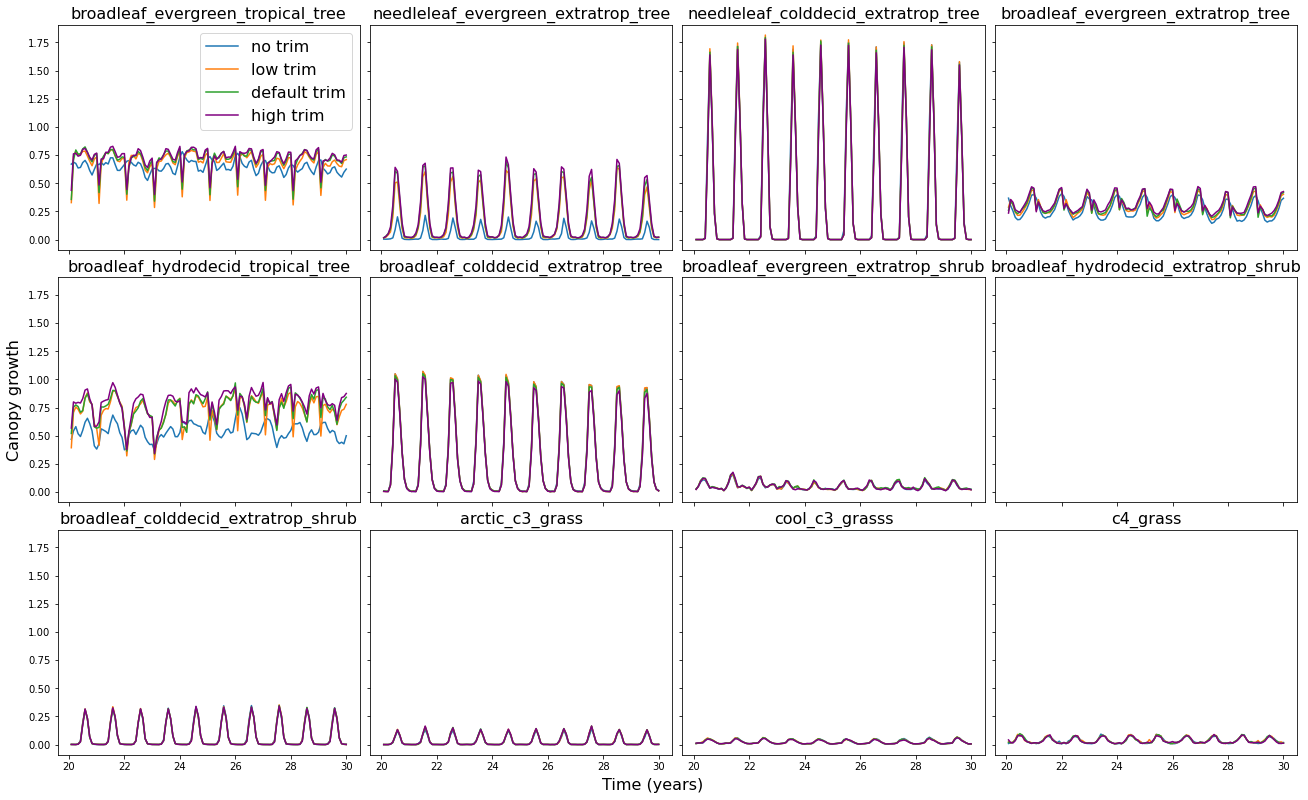

In [14]:
fig, axs = plt.subplots(nrows=3,ncols=4,
                        figsize=(18,11), constrained_layout=True, sharex=True, sharey=True)
axs = axs.flatten()

for  i in range(0,12) :
    axs[i].plot(time, ddbh_canopy_notrim.isel(fates_levpft=i), label = 'no trim')
    axs[i].plot(time, ddbh_canopy_lowtrim.isel(fates_levpft=i), label = 'low trim')
    axs[i].plot(time, ddbh_canopy.isel(fates_levpft=i), label = 'default trim')
    axs[i].plot(time, ddbh_canopy_hightrim.isel(fates_levpft=i), label = 'high trim', color='purple')
    axs[i].set_title(pftnames[i], fontsize=16)

    
axs[0].legend(fontsize=16)

fig.supylabel('Canopy growth', fontsize=16)
fig.supxlabel('Time (years)', fontsize=16)
;

In [15]:
ddbh_ustory = fa.scpf_to_scls_by_pft(fates.FATES_DDBH_USTORY_SZPF, fates) * fates.FATES_FRACTION # multiply by fates fraction
ddbh_ustory = ddbh_ustory.sum(dim='fates_levscls') # sum over sizes
ddbh_ustory  = ddbh_ustory / nplant_u # divide by nplant
ddbh_ustory = ddbh_ustory.mean(dim=['lat','lon']) * 100 # mean over space

ddbh_ustory_notrim = fa.scpf_to_scls_by_pft(fates_notrim.FATES_DDBH_USTORY_SZPF, fates_notrim)* fates_notrim.FATES_FRACTION # multiply by fates fraction
ddbh_ustory_notrim = ddbh_ustory_notrim.sum(dim='fates_levscls') # sum over sizes
ddbh_ustory_notrim  = ddbh_ustory_notrim / nplant_u_notrim # divide by nplant
ddbh_ustory_notrim = ddbh_ustory_notrim.mean(dim=['lat','lon']) * 100 # mean over time

ddbh_ustory_lowtrim = fa.scpf_to_scls_by_pft(fates_lowtrim.FATES_DDBH_USTORY_SZPF, fates_lowtrim)* fates_lowtrim.FATES_FRACTION # multiply by fates fraction 
ddbh_ustory_lowtrim = ddbh_ustory_lowtrim.sum(dim='fates_levscls') # sum over sizes
ddbh_ustory_lowtrim  = ddbh_ustory_lowtrim / nplant_u_lowtrim # divide by nplant
ddbh_ustory_lowtrim = ddbh_ustory_lowtrim.mean(dim=['lat','lon']) * 100 # mean over time

ddbh_ustory_hightrim = fa.scpf_to_scls_by_pft(fates_hightrim.FATES_DDBH_USTORY_SZPF, fates_hightrim)* fates_hightrim.FATES_FRACTION # multiply by fates fraction
ddbh_ustory_hightrim = ddbh_ustory_hightrim.sum(dim='fates_levscls') # sum over sizes
ddbh_ustory_hightrim  = ddbh_ustory_hightrim / nplant_u_hightrim # divide by nplant
ddbh_ustory_hightrim = ddbh_ustory_hightrim.mean(dim=['lat','lon']) * 100 # mean over time


### Understory growth rates (spatially averaged)

''

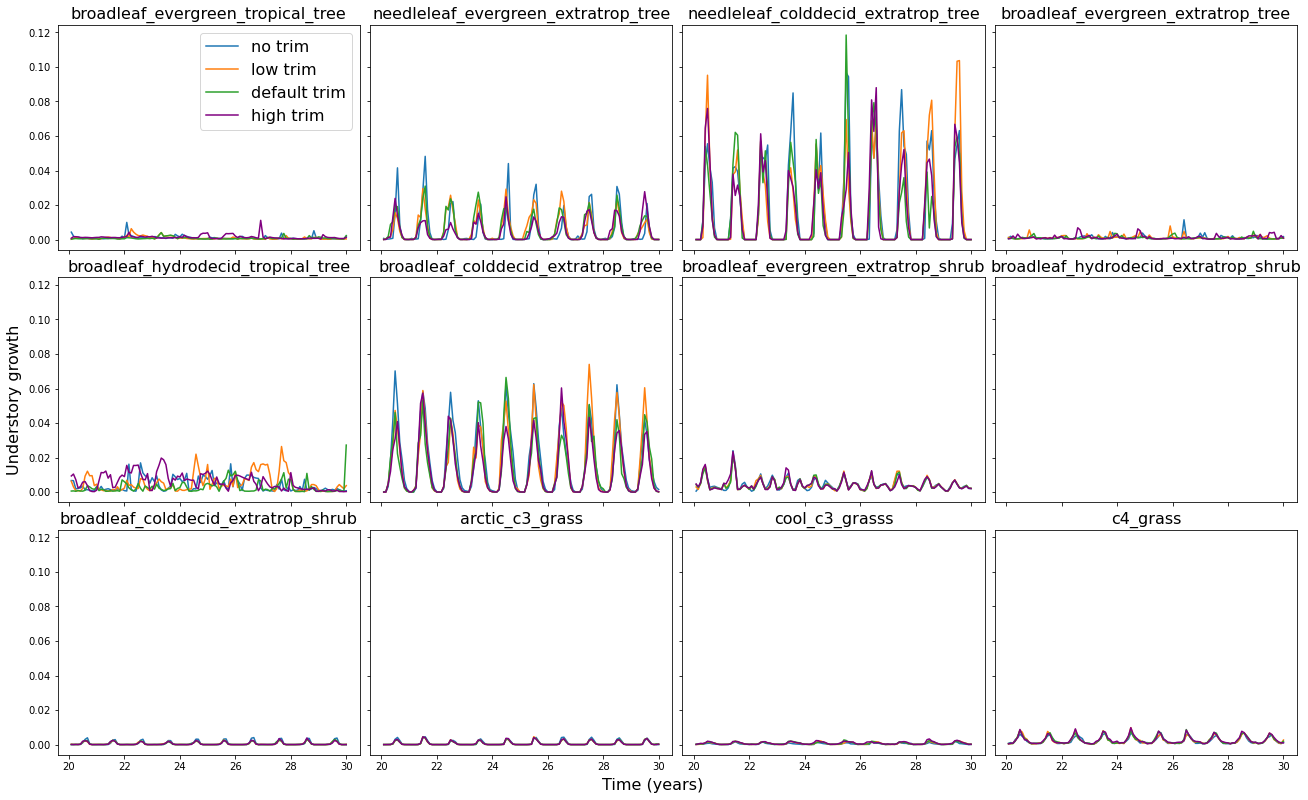

In [16]:
fig, axs = plt.subplots(nrows=3,ncols=4,
                        figsize=(18,11), constrained_layout=True, sharex=True, sharey=True)
axs = axs.flatten()

for  i in range(0,12) :
    axs[i].plot(time, ddbh_ustory_notrim.isel(fates_levpft=i), label = 'no trim')
    axs[i].plot(time, ddbh_ustory_lowtrim.isel(fates_levpft=i), label = 'low trim')
    axs[i].plot(time, ddbh_ustory.isel(fates_levpft=i), label = 'default trim')
    axs[i].plot(time, ddbh_ustory_hightrim.isel(fates_levpft=i), label = 'high trim', color='purple')
    axs[i].set_title(pftnames[i], fontsize=16)

    
axs[0].legend(fontsize=16)

fig.supylabel('Understory growth', fontsize=16)
fig.supxlabel('Time (years)', fontsize=16)
;

#### Growth at 20 cm dbh 

In [17]:
nplant_c = fa.scpf_to_scls_by_pft(fates.FATES_NPLANT_CANOPY_SZPF, fates) * fates.FATES_FRACTION
nplant_u = fa.scpf_to_scls_by_pft(fates.FATES_NPLANT_USTORY_SZPF, fates) * fates.FATES_FRACTION

nplant_c_notrim = fa.scpf_to_scls_by_pft(fates_notrim.FATES_NPLANT_CANOPY_SZPF, fates_notrim) * fates_notrim.FATES_FRACTION
nplant_u_notrim = fa.scpf_to_scls_by_pft(fates_notrim.FATES_NPLANT_USTORY_SZPF, fates_notrim) * fates_notrim.FATES_FRACTION

nplant_c_lowtrim = fa.scpf_to_scls_by_pft(fates_lowtrim.FATES_NPLANT_CANOPY_SZPF, fates_lowtrim) * fates_lowtrim.FATES_FRACTION
nplant_u_lowtrim = fa.scpf_to_scls_by_pft(fates_lowtrim.FATES_NPLANT_USTORY_SZPF, fates_lowtrim) * fates_lowtrim.FATES_FRACTION

nplant_c_hightrim = fa.scpf_to_scls_by_pft(fates_hightrim.FATES_NPLANT_CANOPY_SZPF, fates_hightrim) * fates_hightrim.FATES_FRACTION
nplant_u_hightrim = fa.scpf_to_scls_by_pft(fates_hightrim.FATES_NPLANT_USTORY_SZPF, fates_hightrim) * fates_hightrim.FATES_FRACTION

In [18]:
ddbh_c = fa.scpf_to_scls_by_pft(fates.FATES_DDBH_CANOPY_SZPF, fates) * fates.FATES_FRACTION
ddbh_u = fa.scpf_to_scls_by_pft(fates.FATES_DDBH_USTORY_SZPF, fates) * fates.FATES_FRACTION
ddbh_c = ddbh_c.sel(fates_levscls=10) / nplant_c.sel(fates_levscls=10)
ddbh_u = ddbh_u.sel(fates_levscls=10) / nplant_u.sel(fates_levscls=10)
ddbh_c = ddbh_c.mean(dim=['lat','lon'])
ddbh_u = ddbh_u.mean(dim=['lat','lon'])

ddbh_c_notrim = fa.scpf_to_scls_by_pft(fates_notrim.FATES_DDBH_CANOPY_SZPF, fates_notrim) * fates_notrim.FATES_FRACTION
ddbh_u_notrim = fa.scpf_to_scls_by_pft(fates_notrim.FATES_DDBH_USTORY_SZPF, fates_notrim) * fates_notrim.FATES_FRACTION
ddbh_c_notrim = ddbh_c_notrim.sel(fates_levscls=10) / nplant_c_notrim.sel(fates_levscls=10)
ddbh_u_notrim = ddbh_u_notrim.sel(fates_levscls=10) / nplant_u_notrim.sel(fates_levscls=10)
ddbh_c_notrim = ddbh_c_notrim.mean(dim=['lat','lon'])
ddbh_u_notrim = ddbh_u_notrim.mean(dim=['lat','lon'])

ddbh_c_lowtrim = fa.scpf_to_scls_by_pft(fates_lowtrim.FATES_DDBH_CANOPY_SZPF, fates_lowtrim) * fates_lowtrim.FATES_FRACTION
ddbh_u_lowtrim = fa.scpf_to_scls_by_pft(fates_lowtrim.FATES_DDBH_USTORY_SZPF, fates_lowtrim) * fates_lowtrim.FATES_FRACTION
ddbh_c_lowtrim = ddbh_c_lowtrim.sel(fates_levscls=10) / nplant_c_lowtrim.sel(fates_levscls=10)
ddbh_u_lowtrim = ddbh_u_lowtrim.sel(fates_levscls=10) / nplant_u_lowtrim.sel(fates_levscls=10)
ddbh_c_lowtrim = ddbh_c_lowtrim.mean(dim=['lat','lon'])
ddbh_u_lowtrim = ddbh_u_lowtrim.mean(dim=['lat','lon'])

ddbh_c_hightrim = fa.scpf_to_scls_by_pft(fates_hightrim.FATES_DDBH_CANOPY_SZPF, fates_hightrim) * fates_hightrim.FATES_FRACTION
ddbh_u_hightrim = fa.scpf_to_scls_by_pft(fates_hightrim.FATES_DDBH_USTORY_SZPF, fates_hightrim) * fates_hightrim.FATES_FRACTION
ddbh_c_hightrim = ddbh_c_hightrim.sel(fates_levscls=10) / nplant_c_hightrim.sel(fates_levscls=10)
ddbh_u_hightrim = ddbh_u_hightrim.sel(fates_levscls=10) / nplant_u_hightrim.sel(fates_levscls=10)
ddbh_c_hightrim = ddbh_c_hightrim.mean(dim=['lat','lon'])
ddbh_u_hightrim = ddbh_u_hightrim.mean(dim=['lat','lon'])

''

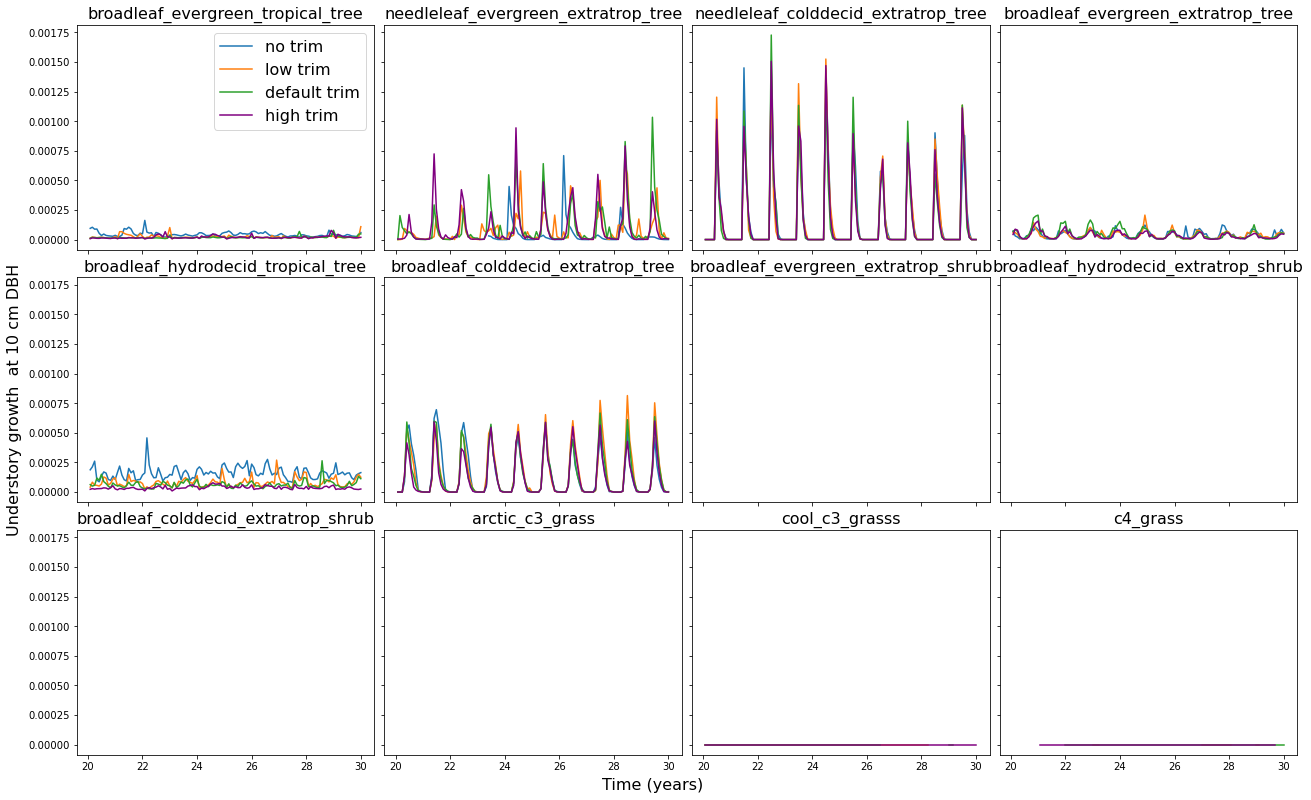

In [19]:
fig, axs = plt.subplots(nrows=3,ncols=4,
                        figsize=(18,11), constrained_layout=True, sharex=True, sharey=True)
axs = axs.flatten()

for  i in range(0,12) :
    axs[i].plot(time, ddbh_u_notrim.isel(fates_levpft=i), label = 'no trim')
    axs[i].plot(time, ddbh_u_lowtrim.isel(fates_levpft=i), label = 'low trim')
    axs[i].plot(time, ddbh_u.isel(fates_levpft=i), label = 'default trim')
    axs[i].plot(time, ddbh_u_hightrim.isel(fates_levpft=i), label = 'high trim', color='purple')
    axs[i].set_title(pftnames[i], fontsize=16)

    
axs[0].legend(fontsize=16)

fig.supylabel('Understory growth  at 10 cm DBH', fontsize=16)
fig.supxlabel('Time (years)', fontsize=16)
;

''

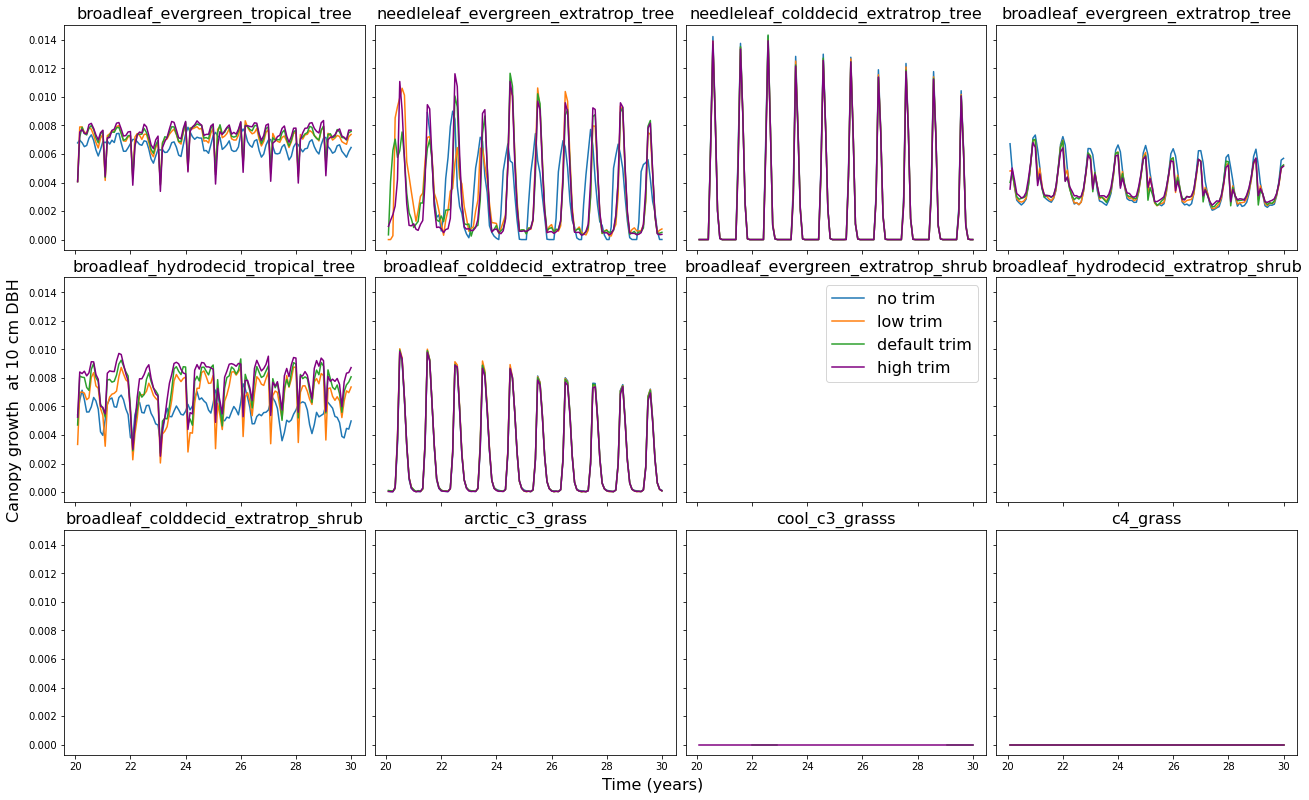

In [20]:
fig, axs = plt.subplots(nrows=3,ncols=4,
                        figsize=(18,11), constrained_layout=True, sharex=True, sharey=True)
axs = axs.flatten()

for  i in range(0,12) :
    axs[i].plot(time, ddbh_c_notrim.isel(fates_levpft=i), label = 'no trim')
    axs[i].plot(time, ddbh_c_lowtrim.isel(fates_levpft=i), label = 'low trim')
    axs[i].plot(time, ddbh_c.isel(fates_levpft=i), label = 'default trim')
    axs[i].plot(time, ddbh_c_hightrim.isel(fates_levpft=i), label = 'high trim', color='purple')
    axs[i].set_title(pftnames[i], fontsize=16)

    
axs[6].legend(fontsize=16)

fig.supylabel('Canopy growth  at 10 cm DBH', fontsize=16)
fig.supxlabel('Time (years)', fontsize=16)
;

### Net carbon uptake by leaf layer 

In [21]:
### Functions
def decay_coeff_kn(vcmax25top):
    ans = np.exp(0.00963 * vcmax25top - 2.43)
    return ans


def clllpf_to_cn_lf_by_pft(clllpf_var, dataset, dataset2):
    """function to reshape a fates multiplexed canopy layer, leaf layer and pft-indexed variable to one indexed by canopy layer leaf layer and pft
    first argument should be an xarray DataArray that has the FATES CLLLPF dimension
    second argument should be an xarray Dataset that has the FATES CLLL dimensions
    (possibly the dataset encompassing the dataarray being transformed)
    returns an Xarray DataArray with the cnlf  (CLLL) and pft dimensions disentangled"""
    n_cnlf = len(dataset.fates_levcnlf)
    ds_out = (clllpf_var.rolling(fates_levcnlfpf=n_cnlf, center=False)
            .construct("fates_levcnlf")
            .isel(fates_levcnlfpf=slice(n_cnlf-1, None, n_cnlf))
            .rename({'fates_levcnlfpf':'fates_levpft'})
            .assign_coords({'fates_levcnlf':dataset.fates_levcnlf})
            .assign_coords({'fates_levpft':dataset.fates_levpft}))
    ds_out.attrs['long_name'] = clllpf_var.attrs['long_name']
    ds_out.attrs['units'] = clllpf_var.attrs['units']
    
    # now create a new dimension - leaf layers - and disentangle canopy layers and leaf layers
    n_levleaf = len(dataset2.fates_levleaf)
    ds_out2 = (ds_out.rolling(fates_levcnlf=n_levleaf, center=False)
               .construct("fates_levleaf")
               .isel(fates_levcnlf=slice(n_levleaf-1, None, n_levleaf))
               .rename({'fates_levcnlf':'fates_levcan'})
               .assign_coords({'fates_levleaf':dataset2.fates_levleaf})
               .assign_coords({'fates_levcan':dataset.fates_levcan}))
    ds_out2.attrs['long_name'] = ds_out.attrs['long_name']
    ds_out2.attrs['units'] = ds_out.attrs['units']
    
    return(ds_out2)

In [22]:
# Leaf construction cost depends on cumulative LAI which corresponds to the leaf layer 
# dimension in CLLLPF. Therefore calculate leaf construction cost for each leaf layer and
# subtract from NET_C_UPTAKE_CLLLPF to get the full net C uptake. 

# PFT level parameters 
vcmax25top = [50, 62, 39, 61, 58, 58, 62, 54, 54, 78, 78, 78]
slatop = [0.018, 0.006, 0.0288, 0.0108, 0.036, 0.036, 0.0144, 0.036, 0.036, 0.036, 0.036, 0.03]
slamax = [ 0.0954, 0.0954, 0.0954, 0.0954, 0.0954, 0.0954, 0.012, 0.03, 0.03, 0.03, 0.03, 0.03]
root_long = [2, 2, 1, 1.5, 1, 1, 1.5, 1, 1, 1, 1, 1]
leaf_long = [2.5, 4, 1, 1.5, 1, 1, 1.5, 1, 1, 1, 1, 1]
season_decid = [0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0]
stress_decid = [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1]
grperc = [ 0.08, 0.11, 0.11, 0.11, 0.11, 0.08, 0.11, 0.11, 0.11, 0.11, 
    0.11, 0.11]
l2fr = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

vai_top_bin_width = 0.1
vai_width_increase_factor = 1.1
nlevleaf = 51 # it is actually 36 but do 37 here to get midpoints
z = np.linspace(1,nlevleaf,nlevleaf)
dinc_vai = vai_top_bin_width * vai_width_increase_factor ** z
cumulative_lais = np.cumsum(dinc_vai)

lower = cumulative_lais[0:-1]
upper = cumulative_lais[1:]
leaf_layer_mids = (lower + upper)*0.5

# make a dataset that has a fates_levleaf dimension
data = np.arange(50)
locs = leaf_layer_mids
dataset2 = xr.DataArray(data, coords={'fates_levleaf':locs}, dims = 'fates_levleaf')


In [23]:
leaf_costs = []

# This is kg C m-2 yr-1 (per unit ground area?)
for pf in range(len(pftnames)):
    
    pft_kn = decay_coeff_kn(vcmax25top[pf])
    nscaler_levleaf = np.exp(-pft_kn * leaf_layer_mids)  
    sla_levleaf = slatop[pf] / nscaler_levleaf
    m = [idx for idx in range(len(sla_levleaf)) if sla_levleaf[idx] > slamax[pf]]
    sla_levleaf[m] = slamax[pf]
    
    # if deciduous
    if(season_decid[pf] == 1) or (stress_decid[pf] == 1):
        # account for sla profile 
        leaf_cost = 1 / (sla_levleaf * 1000) 
        # growth respiration tax
        leaf_cost = (leaf_cost * (grperc[pf] + 1))
    
    # if evergreen    
    else : 
        leaf_cost = (1 / (sla_levleaf * 1000 * leaf_long[pf])) 
        leaf_cost = (leaf_cost * (grperc[pf] + 1)) 
    
    bfr_per_bleaf = l2fr[pf]
    leaf_cost = leaf_cost + ( 1 / (sla_levleaf * 1000) * bfr_per_bleaf / root_long[pf] )
    
    leaf_costs.append(leaf_cost)
    
leaf_costs = xr.DataArray(leaf_costs, dims = ['fates_levpft', 'fates_levleaf'], coords=[np.arange(len(l2fr))+1, leaf_layer_mids])    

#### plot leaf layers 14 - 17 for each case

In [24]:
# clevs=np.arange(-1.,1.,0.1)
# fig, axs = plt.subplots(nrows=4,ncols=4,
#                      subplot_kw={'projection': ccrs.PlateCarree()},
#                      figsize=(18,14))

# axs = axs.flatten()
# counter = 0

# for i in range(0,4) : 
#     if i == 0 : 
#         ds = fates
#     elif i == 1 :
#         ds = fates_notrim
#     elif i == 2 : 
#         ds = fates_lowtrim
#     else : 
#         ds = fates_hightrim

#     # untangle all the dimensions  - this variable is in kg C m-2 s-1 (per ground area NOT leaf area)
#     ds5_raw = clllpf_to_cn_lf_by_pft(ds['FATES_NET_C_UPTAKE_CLLLPF'], ds, dataset2) 
    
#     # divide by crown area  to get net  c uptake on a leaf area basis
#     crownarea = clllpf_to_cn_lf_by_pft(ds['FATES_CROWNAREA_CLLLPF'], ds, dataset2) 
#     ds5 = ds5_raw/crownarea * 86400 * 365
    
#     # Subtract leaf costs from net C uptake ( make net C uptake annual)
#     ds6 = ds5 - leaf_costs

#     # mean over time
#     ds8 = ds6.mean(dim='time')

#     for i in range(14,18):
#         tmp = ds8.isel(fates_levpft=0).isel(fates_levcan=0).isel(fates_levleaf=i)
#         cs = tmp.plot(levels=clevs,cmap='bwr', ax=axs[counter],add_colorbar=False)
#         axs[counter].coastlines()
#         axs[counter].set_title(i)
#         counter = counter  + 1    

# fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
#                     wspace=0.02, hspace=0.03)
# cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
# cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
# cbar.set_label('Net C uptake (kg C m-2 yr-1)')

### Carbon starvation of understory trees

In [25]:
nplant_ustory = fa.scpf_to_scls_by_pft(fates.FATES_NPLANT_USTORY_SZPF, fates)
nplant_ustory = nplant_ustory.sum(dim='fates_levscls') # sum over sizes

nplant_ustory_notrim = fa.scpf_to_scls_by_pft(fates_notrim.FATES_NPLANT_USTORY_SZPF, fates_notrim)
nplant_ustory_notrim = nplant_ustory_notrim.sum(dim='fates_levscls') # sum over sizes

nplant_ustory_lowtrim = fa.scpf_to_scls_by_pft(fates_lowtrim.FATES_NPLANT_USTORY_SZPF, fates_lowtrim)
nplant_ustory_lowtrim = nplant_ustory_lowtrim.sum(dim='fates_levscls') # sum over sizes

nplant_ustory_hightrim = fa.scpf_to_scls_by_pft(fates_hightrim.FATES_NPLANT_USTORY_SZPF, fates_hightrim)
nplant_ustory_hightrim = nplant_ustory_hightrim.sum(dim='fates_levscls') # sum over sizes

In [26]:
cstarv_ustory = fa.scpf_to_scls_by_pft(fates.FATES_M3_MORTALITY_USTORY_SZPF, fates)
cstarv_ustory = cstarv_ustory.sum(dim='fates_levscls') # sum over sizes
cstarv_ustory  = cstarv_ustory / nplant_ustory # divide by nplant
cstarv_ustory = cstarv_ustory.mean(dim='time') # mean over time

cstarv_ustory_notrim = fa.scpf_to_scls_by_pft(fates_notrim.FATES_M3_MORTALITY_USTORY_SZPF, fates_notrim)
cstarv_ustory_notrim = cstarv_ustory_notrim.sum(dim='fates_levscls') # sum over sizes
cstarv_ustory_notrim  = cstarv_ustory_notrim / nplant_ustory_notrim # divide by nplant
cstarv_ustory_notrim = cstarv_ustory_notrim.mean(dim='time') # mean over time

cstarv_ustory_lowtrim = fa.scpf_to_scls_by_pft(fates_lowtrim.FATES_M3_MORTALITY_USTORY_SZPF, fates_lowtrim)
cstarv_ustory_lowtrim = cstarv_ustory_lowtrim.sum(dim='fates_levscls') # sum over sizes
cstarv_ustory_lowtrim  = cstarv_ustory_lowtrim / nplant_ustory_lowtrim # divide by nplant
cstarv_ustory_lowtrim = cstarv_ustory_lowtrim.mean(dim='time') # mean over time

cstarv_ustory_hightrim = fa.scpf_to_scls_by_pft(fates_hightrim.FATES_M3_MORTALITY_USTORY_SZPF, fates_hightrim)
cstarv_ustory_hightrim = cstarv_ustory_hightrim.sum(dim='fates_levscls') # sum over sizes
cstarv_ustory_hightrim  = cstarv_ustory_hightrim / nplant_ustory_hightrim # divide by nplant
cstarv_ustory_hightrim = cstarv_ustory_hightrim.mean(dim='time') # mean over time

In [27]:
cstarv_ustory_list = [cstarv_ustory_notrim, cstarv_ustory_lowtrim, cstarv_ustory, cstarv_ustory_hightrim]

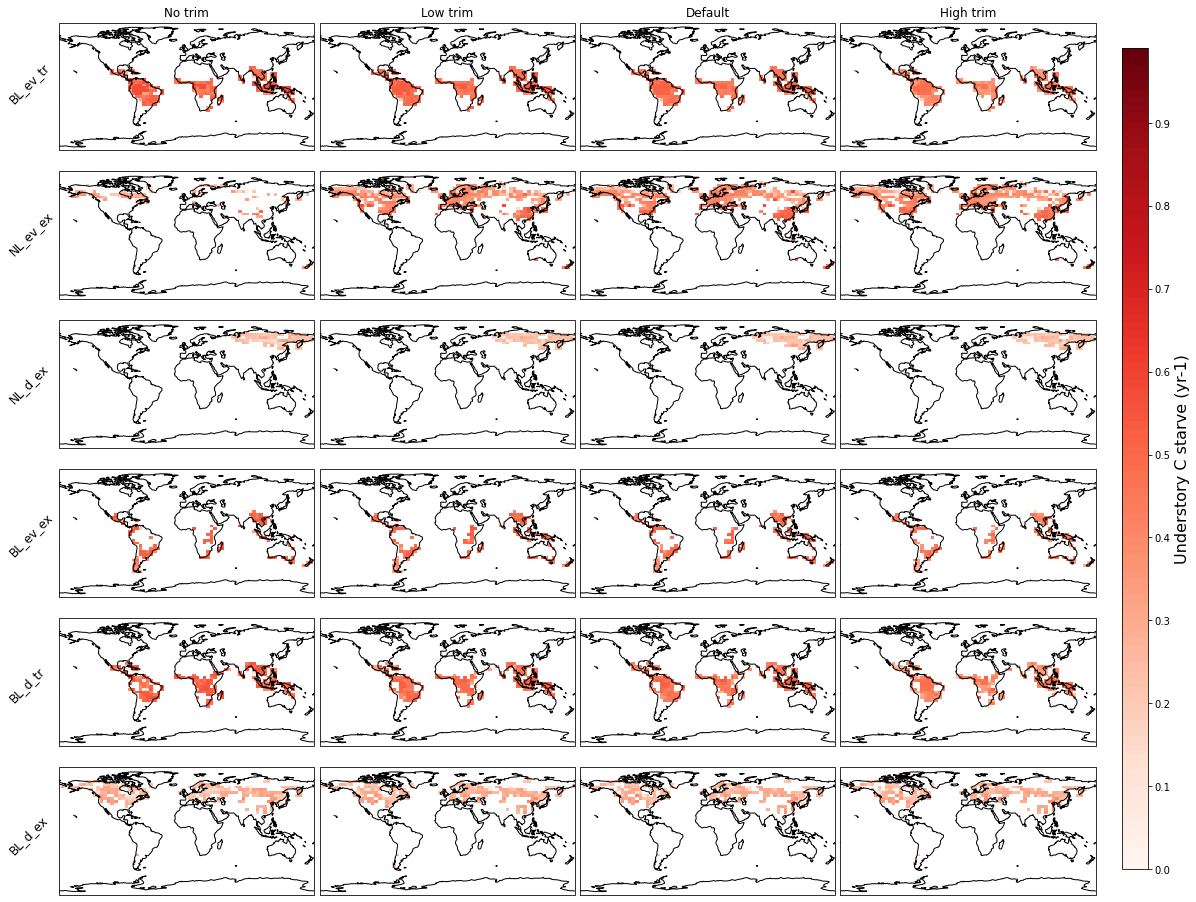

In [28]:
clevs=np.arange(0,1.0,0.01)
fig, axs = plt.subplots(nrows=6,ncols=4,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,19))
for j in range(0,4):
    tmp = cstarv_ustory_list[j]
    
    for i in range(0,6):
            cs= tmp.isel(fates_levpft=i).plot(levels=clevs,cmap='Reds',
            ax=axs[i,j],add_colorbar=False)
            axs[i,j].coastlines()
            axs[i,j].set_title('')
            
axs[0,0].set_title('No trim', fontsize=12)
axs[0,1].set_title('Low trim', fontsize=12)
axs[0,2].set_title('Default', fontsize=12)
axs[0,3].set_title('High trim', fontsize=12)

fig.text(0.06, 0.85, 'BL_ev_tr', va='center', rotation=45.0, fontsize=12)
fig.text(0.06, 0.74, 'NL_ev_ex', va='center', rotation=45.0, fontsize=12)
fig.text(0.06, 0.63, 'NL_d_ex', va='center', rotation=45.0, fontsize=12)
fig.text(0.06, 0.52, 'BL_ev_ex', va='center', rotation=45.0, fontsize=12)
fig.text(0.06, 0.41, 'BL_d_tr', va='center', rotation=45.0, fontsize=12)
fig.text(0.06, 0.3, 'BL_d_ex', va='center', rotation=45.0, fontsize=12)

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Understory C starve (yr-1)',fontsize=16)

### Total GPP, NPP and CUE for each run

In [29]:
gpp = fates.FATES_GPP.mean(dim='time') * fates.FATES_FRACTION.mean(dim='time') * 86400 * 365
gpp_notrim = fates_notrim.FATES_GPP.mean(dim='time') * fates.FATES_FRACTION.mean(dim='time')  * 86400 * 365 
gpp_lowtrim = fates_lowtrim.FATES_GPP.mean(dim='time') * fates.FATES_FRACTION.mean(dim='time')  * 86400 * 365
gpp_hightrim = fates_hightrim.FATES_GPP.mean(dim='time') * fates.FATES_FRACTION.mean(dim='time') * 86400 * 365

In [30]:
npp = fates.FATES_NPP_SZPF.sum(dim='fates_levscpf')* fates.FATES_FRACTION # multiply by fates fraction
npp = npp.mean(dim='time')  * 86400 * 365 

npp_notrim = fates_notrim.FATES_NPP_SZPF.sum(dim='fates_levscpf')* fates_notrim.FATES_FRACTION # multiply by fates fraction
npp_notrim = npp_notrim.mean(dim='time') * 86400 * 365

npp_lowtrim = fates_lowtrim.FATES_NPP_SZPF.sum(dim='fates_levscpf')* fates_lowtrim.FATES_FRACTION # multiply by fates fraction
npp_lowtrim = npp_lowtrim.mean(dim='time') * 86400 * 365

npp_hightrim = fates_hightrim.FATES_NPP_SZPF.sum(dim='fates_levscpf')* fates_hightrim.FATES_FRACTION # multiply by fates fraction
npp_hightrim = npp_hightrim.mean(dim='time') * 86400 * 365

In [31]:
cue = npp/gpp
cue_notrim = npp_notrim/gpp_notrim
cue_lowtrim = npp_lowtrim/gpp_lowtrim
cue_hightrim = npp_hightrim/gpp_hightrim

In [32]:
gpp_list = [gpp_notrim, gpp_lowtrim, gpp, gpp_hightrim]
npp_list = [npp_notrim, npp_lowtrim, npp, npp_hightrim]
cue_list = [cue_notrim, cue_lowtrim, cue, cue_hightrim]

In [33]:
print(npp.shape)

(46, 72)


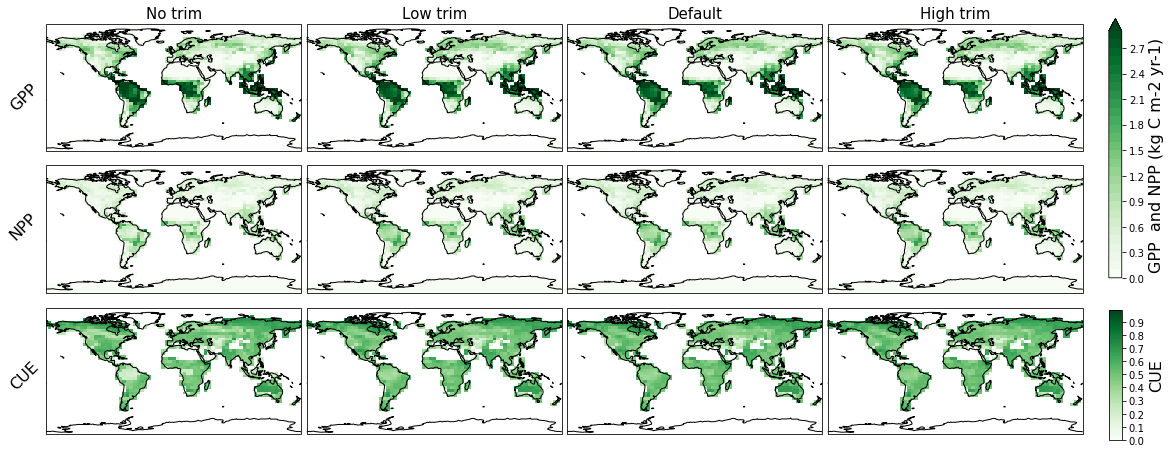

In [34]:
fig, axs = plt.subplots(nrows=3,ncols=4,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,9))
for j in range(0,4):
            clevs=np.arange(0,3.0,0.1)
            gpp_cs = gpp_list[j].plot(levels=clevs,cmap='Greens', ax=axs[0,j],add_colorbar=False)
            axs[0,j].coastlines()
            axs[0,j].set_title('')
            npp_cs = npp_list[j].plot(levels=clevs,cmap='Greens', ax=axs[1,j],add_colorbar=False)
            axs[1,j].coastlines()
            axs[1,j].set_title('')
            clevs=np.arange(0,1.0,0.01)
            cue_cs = cue_list[j].plot(levels=clevs,cmap='Greens', ax=axs[2,j],add_colorbar=False)
            axs[2,j].coastlines()
            axs[2,j].set_title('')
            
            
axs[0,0].set_title('No trim', fontsize=15)
axs[0,1].set_title('Low trim', fontsize=15)
axs[0,2].set_title('Default', fontsize=15)
axs[0,3].set_title('High trim', fontsize=15)

fig.text(0.07, 0.78, 'GPP', va='center', rotation=45.0, fontsize=16)
fig.text(0.07, 0.58, 'NPP', va='center', rotation=45.0, fontsize=16)
fig.text(0.07, 0.35, 'CUE', va='center', rotation=45.0, fontsize=16)

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)

cbar_ax = fig.add_axes([0.92, 0.5, 0.01, 0.4])
cbar=fig.colorbar(gpp_cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('GPP  and NPP (kg C m-2 yr-1)',fontsize=16)

cbar_ax = fig.add_axes([0.92, 0.25, 0.01, 0.2])
cbar=fig.colorbar(cue_cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('CUE',fontsize=16)